In [1]:
import seaborn as sns
import scipy.io
import pandas as pd
import numpy as np
import os.path
from os import path
import matplotlib.pyplot as plt

In [87]:
def Read(threshold,idistribution,ivirus_proda,ivirus_prodb,ivirus_diff,iifn_prod,iifn_prob,ires_ratio,ivirus_type_ratio,step_size):
    filename = "{}_virusproda{}_virusprodb{}_virusdiff{}_ifnprod{}_ifnprob{}_resratio{}_virustyperatio{}_dim{}_sim{}_step{}".format(idistribution,ivirus_proda,ivirus_prodb,ivirus_diff,iifn_prod,iifn_prob,ires_ratio,ivirus_type_ratio,100,100,step_size)
    matfile = "./data/results_{}.mat".format(filename)
    mat = scipy.io.loadmat(matfile)
    infected_count=mat['infected_count']
    protected_count=mat['protected_count']
    dead_count=mat['dead_count']
    reservoir_count=mat['reservoir_count']
    virus_count=mat['virus_count']
    ifn_count=mat['ifn_count']
    virus_contact=mat['virus_contact']
    ifn_contact=mat['ifn_contact']
    virus_type1=mat['virus_type1']
    virus_type2=mat['virus_type2']
    

    total=[]
    for irun in range(len(infected_count)):
        infected_array = infected_count[irun]
        infected_max = infected_array.max()
        if infected_max> threshold:
            for istep in range(len(infected_count[irun])):
                infected = infected_count[irun][istep]
                protected = protected_count[irun][istep]
                dead = dead_count[irun][istep]
                reservoir = reservoir_count[irun][istep]
                virus_generating = virus_count[irun][istep]
                ifn_generating=ifn_count[irun][istep]
                virus_contacting = virus_contact[irun][istep]
                ifn_contacting = ifn_contact[irun][istep]
                virus1 = virus_type1[irun][istep]
                virus2 = virus_type2[irun][istep]
                if infected>0:
                    virustyperatio = virus2/(virus1+virus2)
                else:
                    virustyperatio = 0
                data = {"run":irun,"step":istep,"distribution":idistribution,"virus_prod 1":ivirus_proda,"virus_prod 2":ivirus_prodb,"virus_diff":ivirus_diff,"ifn_prob":iifn_prob,"ifn_prod":iifn_prod,"res_ratio":ires_ratio,"virus_type_ratio":ivirus_type_ratio,"infected":infected,"protected":protected,"dead":dead,"reservoir":reservoir,"virus_generating":virus_generating,"virus_contacting":virus_contacting,"ifn_generating":ifn_generating,"ifn_contacting":ifn_contacting,"virustype1":virus1,"virustype2": virus2,"virustyperatio":virustyperatio}
                total.append(data)
    df = pd.DataFrame(total)
    return df
    

In [88]:
def ReadSets(threshold,ifn_prod,res_ratio,virus_type_ratio):
    step = 5
    virus_prod = [[2,1.8]]
    virus_diff=[0.5]
    ifn_prob=[10]
    distribution=['negbinomial']
    virus_reduction=[10]

    step_size = 365*step
    runs = 100
    virus_prod_delay=5
    ifn_prod_delay=5
    lifespan=10
    total=[]
    for idistribution in distribution:
        for ivirus_proda,ivirus_prodb in virus_prod:
            for ivirus_diff in virus_diff:
                for iifn_prob in ifn_prob: 
                    for iifn_prod in ifn_prod:
                        for ires_ratio in res_ratio:
                            for ivirus_type_ratio in virus_type_ratio:
                                df = Read(threshold,idistribution,ivirus_proda,ivirus_prodb,ivirus_diff,iifn_prod,iifn_prob,ires_ratio,ivirus_type_ratio,step_size)
                                total.append(df)
    dftot = pd.concat(total)
    return dftot

In [136]:
def CalculateParMean(par):
    par_array = par.to_numpy()
    par_mean = par_array.mean()
    par_std = par_array.std()
    return par_mean,par_std

def CalculateCellsMean(df,ifn_prod,res_ratio,virus_type_ratio):
    total=[]
    for iifn_prod in ifn_prod:
        for ires_ratio in res_ratio:
            for ivirus_type_ratio in virus_type_ratio:
                df1 = df[(df["ifn_prod"]==iifn_prod) & (df["res_ratio"]==ires_ratio) & (df["virus_type_ratio"]==ivirus_type_ratio)]            
                for istep in df1["step"].unique():
                    df2=df1[df1["step"]==istep]
                    infected_mean, infected_std = CalculateParMean(df2["infected"])
                    protected_mean, protected_std = CalculateParMean(df2["protected"])
                    dead_mean, dead_std = CalculateParMean(df2["dead"])
                    reservoir_mean, reservoir_std = CalculateParMean(df2["reservoir"])
    
                    
                    virustype1_mean, virustype1_std = CalculateParMean(df2["virustype1"])
                    virustype2_mean, virustype2_std = CalculateParMean(df2["virustype2"])
                    data = {"step":istep,
                            "ifn_prod":iifn_prod,"res_ratio":ires_ratio,"virus_type_ratio":ivirus_type_ratio,
                            "infected_mean":infected_mean,"infected_std":infected_std,
                            "protected_mean":protected_mean,"protected_std":protected_std,
                            "dead_mean":dead_mean,"dead_std":dead_std,
                            "reservoir_mean":reservoir_mean,"reservoir_std":reservoir_std,
                            "virustype1_mean":virustype1_mean,"virustype1_std":virustype1_std,
                            "virustype2_mean":virustype2_mean,"virustype2_std":virustype2_std
                           }
                    total.append(data)
    dfmean = pd.DataFrame(total)
    return dfmean


def PlotCellsMean(df,threshold,virus_prod,ifn_prod,res_ratio,virus_type_ratio):
    for iifn_prod in ifn_prod:
        for ires_ratio in res_ratio:
            for ivirus_type_ratio in virus_type_ratio:
                df1 = df[(df["ifn_prod"]==iifn_prod) & (df["res_ratio"]==ires_ratio) & (df["virus_type_ratio"]==ivirus_type_ratio)]            
                plt.figure(figsize=(5, 3))
                plt.scatter(df1['step']/step,df1['infected_mean'],s=0.5,label='_nolegend_')
                markers, caps, bars1=plt.errorbar(df1['step']/step,df1['infected_mean'], yerr=df1['infected_std'], label="infected")
                [bar1.set_alpha(0.05) for bar1 in bars1]
                plt.scatter(df1['step']/step,df1['protected_mean'],s=0.5,label='_nolegend_')
                markers, caps, bars1=plt.errorbar(df1['step']/step,df1['protected_mean'], yerr=df1['protected_std'], label="protected")
                [bar1.set_alpha(0.05) for bar1 in bars1]
                plt.scatter(df1['step']/step,df1['dead_mean'],s=0.5,label='_nolegend_')
                markers, caps, bars1=plt.errorbar(df1['step']/step,df1['dead_mean'], yerr=df1['dead_std'], label="dead")
                [bar1.set_alpha(0.05) for bar1 in bars1]
                res_corr_ratio = 1*(1-ivirus_type_ratio/100)+2*ivirus_type_ratio/100
                plt.scatter(df1['step']/step,df1['reservoir_mean']*100/res_corr_ratio,s=0.5,label='_nolegend_')
                markers, caps, bars1=plt.errorbar(df1['step']/step,df1['reservoir_mean']*100/res_corr_ratio, yerr=df1['reservoir_std']*100/res_corr_ratio, label="reservoir*100")
                [bar1.set_alpha(0.05) for bar1 in bars1]
                plt.ylabel("Cell Number")
                plt.xlabel("Days")
                plt.subplots_adjust(left=0.18, right=0.97, top=0.9, bottom=0.15)
                plt.title('ifn_prod={},res_ratio={}%,virus_type_ratio={}%'.format(iifn_prod,ires_ratio,ivirus_type_ratio))
                plt.legend()
                plt.savefig("./figure/cells_virusproda{}_virusprodb{}_ifnprod{}_resratio{}_virustyperatio{}_{}.pdf".format(virus_prod[0],virus_prod[1],iifn_prod,ires_ratio,ivirus_type_ratio,threshold))
                plt.show()
                
                plt.figure(figsize=(5, 3))
                plt.scatter(df1['step']/step,df1['virustype1_mean'],s=0.5,label="_nolegned_")
                plt.scatter(df1['step']/step,df1['virustype2_mean'],s=0.5,label="_nolegned_")
                markers, caps, bars1=plt.errorbar(df1['step']/step,df1['virustype1_mean'], yerr=df1['virustype1_std'], label="non-res")
                [bar1.set_alpha(0.05) for bar1 in bars1]
                markers, caps, bars2=plt.errorbar(df1['step']/step,df1['virustype2_mean'], yerr=df1['virustype2_std'], label="res")
                [bar2.set_alpha(0.05) for bar2 in bars2]
                plt.ylabel("Infected Cells (non-res, res)")
                plt.xlabel("Days")
                plt.subplots_adjust(left=0.18, right=0.97, top=0.9, bottom=0.15)
                plt.title('ifn_prod={},res_ratio={}%,virus_type_ratio={}%'.format(iifn_prod,ires_ratio,ivirus_type_ratio))
                plt.legend()
                plt.savefig("./figure/infectcell_virusproda{}_virusprodb{}_ifnprod{}_resratio{}_virustyperatio{}_{}.pdf".format(virus_prod[0],virus_prod[1],iifn_prod,ires_ratio,ivirus_type_ratio,threshold))
                plt.show()

/Users/pchu/anaconda3/lib/python3.7/site-packages/scipy/io/matlab/mio.py:142: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/Users/pchu/anaconda3/lib/python3.7/site-packages/scipy/io/matlab/mio.py:142: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/Users/pchu/anaconda3/lib/python3.7/site-packages/scipy/io/matlab/mio.py:142: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/Users/pchu/anaconda3/lib/python3.7/site-packages/scipy/io/matlab/mio.py:142: MatReadWarning: Duplicate variable name "None" in stream - re

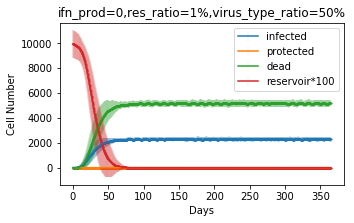

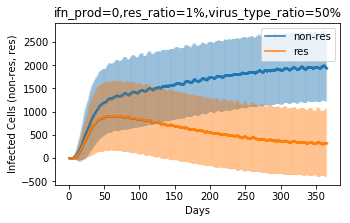

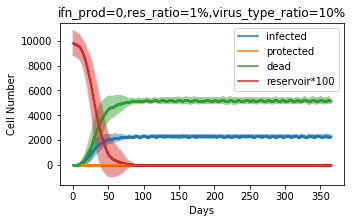

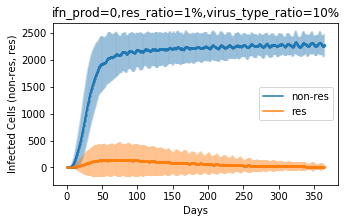

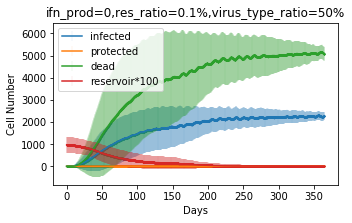

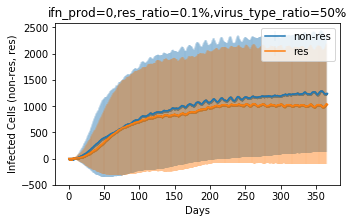

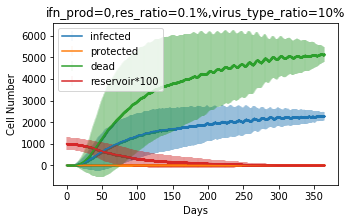

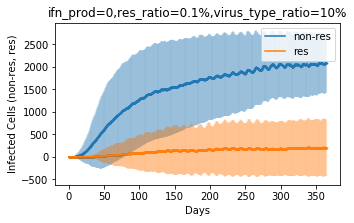

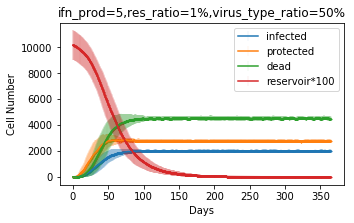

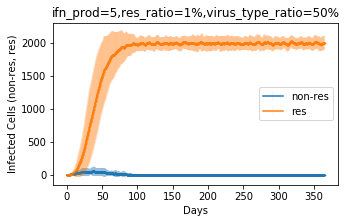

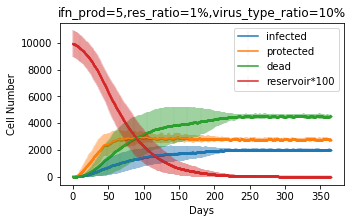

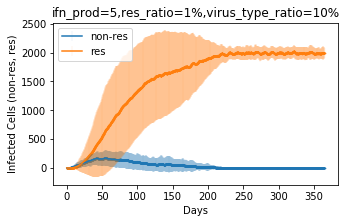

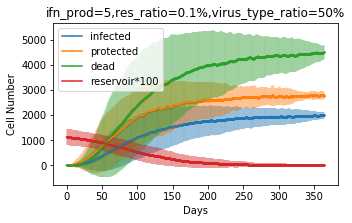

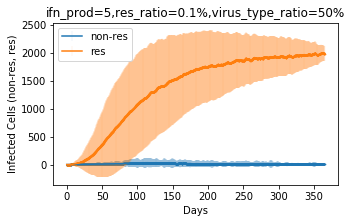

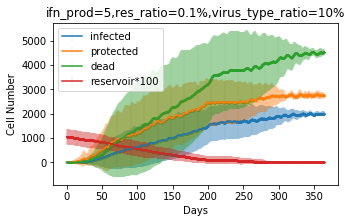

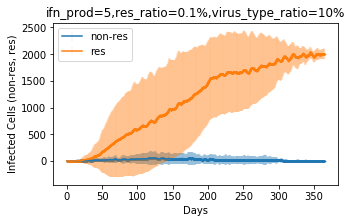

In [91]:
threshold = 1000
virus_prod=[2,1.8]
ifn_prod=[0,5]
res_ratio=[1,0.1]
virus_type_ratio=[50,10]
df1 = ReadSets(threshold,ifn_prod,res_ratio,virus_type_ratio)
df2 = CalculateCellsMean(df1,ifn_prod,res_ratio,virus_type_ratio)
PlotCellsMean(df2,threshold,virus_prod,ifn_prod,res_ratio,virus_type_ratio)

In [167]:
def CalculateVirusTypeRatioATThreshold(df,threshold,ifn_prod,res_ratio,virus_type_ratio):
    total=[]
    for iifn_prod in ifn_prod:
        for ires_ratio in res_ratio:
            for ivirus_type_ratio in virus_type_ratio:
                df1 = df[(df["ifn_prod"]==iifn_prod) & (df["res_ratio"]==ires_ratio) & (df["virus_type_ratio"]==ivirus_type_ratio)]            
                for irun in df1["run"].unique():
                    df2=df1[df1["run"]==irun]
                    for istep in df2["step"].unique():
                        df3=df2[df2["step"]==istep]
                        infected=df3["infected"].iloc[0]
                        if infected>= threshold:
                            virus1 = df3["virustype1"].iloc[0]
                            virus2 = df3["virustype2"].iloc[0]
                            virus_type_ratio_threshold=virus2/(virus1+virus2)
                            step_threshold = istep
                            data = {
                                "ifn_prod":iifn_prod,"res_ratio":ires_ratio,"virus_type_ratio":ivirus_type_ratio,
                                "virus1_threshold":virus1,"virus2_threshold":virus2,
                                "virustyperatio_threshold":virus_type_ratio_threshold,
                                "step_threshold":step_threshold
                            }
                            total.append(data)
                            break
    dfthreshold = pd.DataFrame(total)
    return dfthreshold

def CalculateVirusTypeRatioATThresholdMean(df,ifn_prod,res_ratio,virus_type_ratio):
    total=[]
    for iifn_prod in ifn_prod:
        for ires_ratio in res_ratio:
            for ivirus_type_ratio in virus_type_ratio:
                df1 = df[(df["ifn_prod"]==iifn_prod) & (df["res_ratio"]==ires_ratio) & (df["virus_type_ratio"]==ivirus_type_ratio)]            
                #virus1_threshold_mean,virus1_threshold_std=CalculateParMean(df1["virus1_threshold"])
                #virus2_threshold_mean,virus2_threshold_std=CalculateParMean(df1["virus2_threshold"])
                efficiency = len(df1)/100
                eff_unc =np.sqrt(len(df1))/100
                virustyperatio_threshold_mean,virustyperatio_threshold_std=CalculateParMean(df1["virustyperatio_threshold"])
                step_threshold_mean,step_threshold_std=CalculateParMean(df1["step_threshold"])
                
                data = {
                    "ifn_prod":iifn_prod,"res_ratio":ires_ratio,"virus_type_ratio":ivirus_type_ratio,
                    "virustyperatio_threshold_mean":virustyperatio_threshold_mean,
                    "virustyperatio_threshold_std":virustyperatio_threshold_std,
                    "step_threshold_mean":step_threshold_mean,
                    "step_threshold_std":step_threshold_std,
                    "efficiency":efficiency,
                    "eff_unc":eff_unc
                }
                total.append(data)
                           
    dfthreshold = pd.DataFrame(total)
    return dfthreshold


In [168]:
#Case 1
threshold = 1000
virus_prod=[2,1.8]
ifn_prod=[0,1,2,3,4,5]
res_ratio=[0.1,1]
virus_type_ratio=[10,50]
#df11 = ReadSets(threshold,ifn_prod,res_ratio,virus_type_ratio)
#df21 = CalculateVirusTypeRatioATThreshold(df11,threshold,ifn_prod,res_ratio,virus_type_ratio)
df31 = CalculateVirusTypeRatioATThresholdMean(df21,ifn_prod,res_ratio,virus_type_ratio)

In [170]:
#Case 2
threshold = 1000
virus_prod=[2,1.8]
ifn_prod=[5]
res_ratio=[0.1,1]
virus_type_ratio=[0,5,10,20,30,50,100]
#df12 = ReadSets(threshold,ifn_prod,res_ratio,virus_type_ratio)
#df22 = CalculateVirusTypeRatioATThreshold(df12,threshold,ifn_prod,res_ratio,virus_type_ratio)
df32 = CalculateVirusTypeRatioATThresholdMean(df22,ifn_prod,res_ratio,virus_type_ratio)

/Users/pchu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/pchu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/pchu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/pchu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/Users/pchu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/pchu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipyk

In [171]:
#Case 3
threshold = 1000
virus_prod=[2,1.8]
ifn_prod=[5]
res_ratio=[0.01,0.05,0.1,0.5,1]
virus_type_ratio=[10,50]
#df13 = ReadSets(threshold,ifn_prod,res_ratio,virus_type_ratio)
#df23 = CalculateVirusTypeRatioATThreshold(df13,threshold,ifn_prod,res_ratio,virus_type_ratio)
df33 = CalculateVirusTypeRatioATThresholdMean(df23,ifn_prod,res_ratio,virus_type_ratio)

In [183]:
def PlotVirusTypeRatioATThreshold_ifn_prod(df):
    colors=['blue', 'red']
    linestyles = ['-.','--']
    markers = ['o','s']


    for ires_ratio in df["res_ratio"].unique():  
        df1=df[(df['res_ratio']==ires_ratio)]
        count1=0
        count2=0
        plt.figure(figsize=(5, 5))
        for ivirus_type_ratio in df1["virus_type_ratio"].unique():
            df2=df1[(df1["virus_type_ratio"]==ivirus_type_ratio)]
            plt.errorbar(df2['ifn_prod'],df2["step_threshold_mean"]/step, yerr=df2["step_threshold_std"]/step, color=colors[count1],marker = markers[count1],capsize=6,linestyle=linestyles[count1],label="Initial fraction of IFN resistent virus ={}%".format(ivirus_type_ratio))
            count1=count1+1
        plt.title("Fraction of Reservoir Cell = {}%".format(ires_ratio))
        plt.ylabel("Days to rebound")
        plt.xlabel("IFN production")
        plt.subplots_adjust(left=0.15, right=0.9, top=0.7, bottom=0.15)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.33),ncol=1)
        plt.savefig("./figure/daystorebound_ifnprod_res_ratio{}.pdf".format(ires_ratio))
        plt.show()   
        
        plt.figure(figsize=(5, 5))
        for ivirus_type_ratio in df1["virus_type_ratio"].unique():
            df2=df1[(df1["virus_type_ratio"]==ivirus_type_ratio)]
            plt.errorbar(df2['ifn_prod'],df2["virustyperatio_threshold_mean"], yerr=df2["virustyperatio_threshold_std"], color=colors[count2],marker = markers[count2],capsize=6,linestyle=linestyles[count2],label="Initial fraction of IFN resistent virus ={}%".format(ivirus_type_ratio))
            count2=count2+1
        plt.title("Fraction of Reservoir Cell = {}%".format(ires_ratio))
        plt.ylabel("Fraction of IFN resistant virus at rebound (%)")
        plt.xlabel("IFN production")
        plt.subplots_adjust(left=0.15, right=0.9, top=0.7, bottom=0.15)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.33),ncol=1)
        plt.savefig("./figure/virustyperatio_ifnprod_res_ratio{}.pdf".format(ires_ratio))
        plt.show()         

    return 0

def PlotVirusTypeRatioATThreshold_ifn_prod_violin(df):
    colors=['blue', 'red']
    linestyles = ['-.','--']
    markers = ['o','s']


    for ires_ratio in df["res_ratio"].unique():  
        df1=df[(df['res_ratio']==ires_ratio)]
        plt.figure(figsize=(5, 5))
        ax=sns.violinplot(x="ifn_prod",y=df1["step_threshold"].astype(float)/step,hue="virus_type_ratio",data=df1)
        plt.title("Fraction of Reservoir Cell = {}%".format(ires_ratio))
        plt.ylabel("Days to rebound")
        plt.xlabel("IFN production")
        plt.subplots_adjust(left=0.15, right=0.9, top=0.7, bottom=0.15)
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),ncol=1,handles=ax.legend_.legendHandles,labels=['Fraction of IFN resistent virus=10%', 'Fraction of IFN resistent virus=50%'])
        plt.savefig("./figure/daystorebound_ifnprod_res_ratio{}_violin.pdf".format(ires_ratio))
        plt.show()   
        
        plt.figure(figsize=(5, 5))
        ax=sns.violinplot(x="ifn_prod",y=100*df1["virustyperatio_threshold"],hue="virus_type_ratio",data=df1)
        plt.title("Fraction of Reservoir Cell = {}%".format(ires_ratio))
        plt.ylabel("Fraction of IFN resistant virus at rebound (%)")
        plt.xlabel("IFN production")
        plt.subplots_adjust(left=0.15, right=0.9, top=0.7, bottom=0.15)
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),ncol=1,handles=ax.legend_.legendHandles,labels=['Fraction of IFN resistent virus=10%', 'Fraction of IFN resistent virus=50%'])
        plt.savefig("./figure/virustyperatio_ifnprod_res_ratio{}_violin.pdf".format(ires_ratio))
        plt.show()         

    return 0

def PlotVirusTypeRatioATThreshold_ifn_prod_efficiency(df):
    colors=['blue', 'red']
    linestyles = ['-.','--']
    markers = ['o','s']


    for ires_ratio in df["res_ratio"].unique():  
        df1=df[(df['res_ratio']==ires_ratio)]
        count2=0
        plt.figure(figsize=(5, 5))
        for ivirus_type_ratio in df1["virus_type_ratio"].unique():
            df2=df1[(df1["virus_type_ratio"]==ivirus_type_ratio)]
            plt.errorbar(df2['ifn_prod'],df2["efficiency"]*100, yerr=df2["eff_unc"]*100, color=colors[count2],marker = markers[count2],capsize=6,linestyle=linestyles[count2],label="Initial fraction of IFN resistent virus ={}%".format(ivirus_type_ratio))
            count2=count2+1
        plt.title("Fraction of Reservoir Cell = {}%".format(ires_ratio))
        plt.ylabel("Efficiency (%)")
        plt.xlabel("IFN production")
        plt.subplots_adjust(left=0.15, right=0.9, top=0.7, bottom=0.15)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.33),ncol=1)
        plt.savefig("./figure/virustyperatio_ifnprod_res_ratio{}_eff.pdf".format(ires_ratio))
        plt.show()         

    return 0

/Users/pchu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


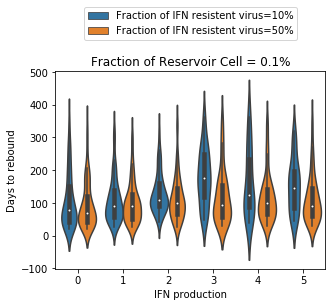

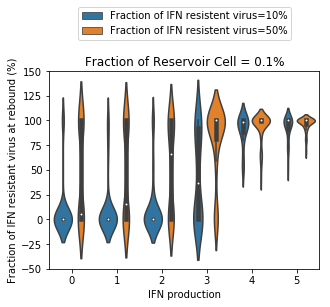

/Users/pchu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


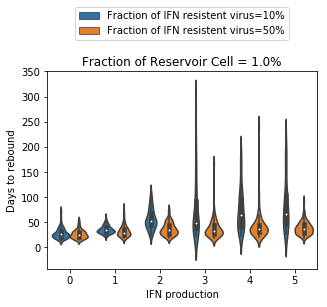

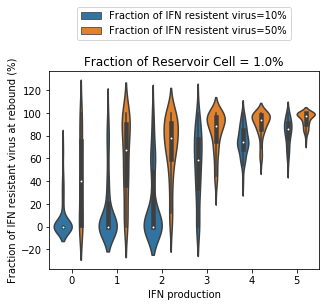

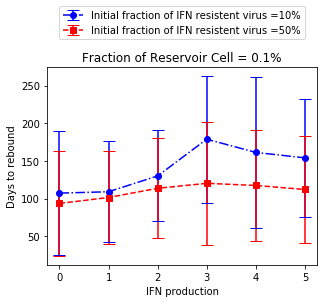

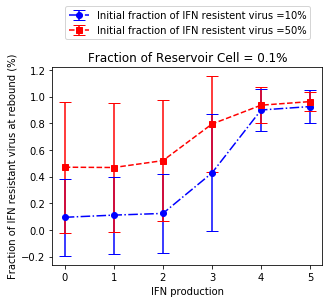

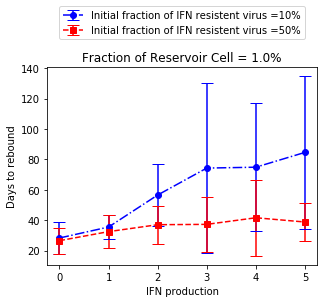

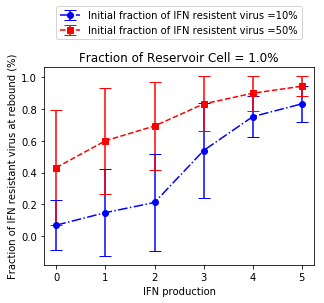

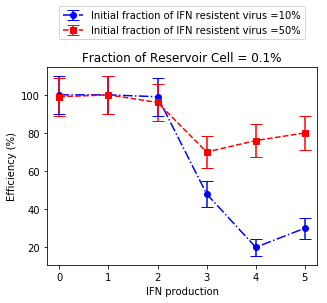

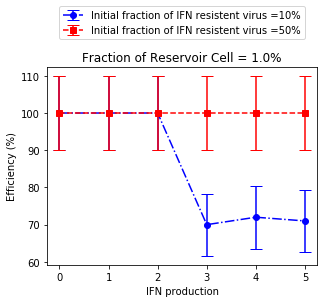

0

In [184]:
PlotVirusTypeRatioATThreshold_ifn_prod_violin(df21)
PlotVirusTypeRatioATThreshold_ifn_prod(df31)
PlotVirusTypeRatioATThreshold_ifn_prod_efficiency(df31)

In [179]:
def PlotVirusTypeRatioATThreshold_virustyperatio(df):
    colors=['blue', 'red']
    linestyles = ['-.','--']
    markers = ['o','s']

    for iifn_prod in df["ifn_prod"].unique():
        df1=df[(df['ifn_prod']==iifn_prod)]
        count1=0
        count2=0
        plt.figure(figsize=(5, 5))
        for ires_ratio in df["res_ratio"].unique():  
            df2=df1[(df1["res_ratio"]==ires_ratio)]
            plt.errorbar(df2['virus_type_ratio'],df2["step_threshold_mean"]/step, yerr=df2["step_threshold_std"]/step, color=colors[count1],marker = markers[count1],capsize=6,linestyle=linestyles[count1],label="Fraction of reservoir cell ={}%".format(ires_ratio))
            count1=count1+1
        plt.title("IFN production = {}".format(iifn_prod))
        plt.ylabel("Days to rebound")
        plt.xlabel("Fraction of IFN resistent virus (%)")
        plt.subplots_adjust(left=0.15, right=0.9, top=0.7, bottom=0.15)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.33),ncol=1)
        plt.savefig("./figure/daystorebound_virustyperatio_ifnprod{}.pdf".format(iifn_prod))
        plt.show()   
        
        plt.figure(figsize=(5, 5))
        for ires_ratio in df["res_ratio"].unique():  
            df2=df1[(df1["res_ratio"]==ires_ratio)]
            plt.errorbar(df2['virus_type_ratio'],df2["virustyperatio_threshold_mean"], yerr=df2["virustyperatio_threshold_std"], color=colors[count2],marker = markers[count2],capsize=6,linestyle=linestyles[count2],label="Fraction of reservoir cell ={}%".format(ires_ratio))
            count2=count2+1
        plt.title("IFN production = {}".format(iifn_prod))
        plt.ylabel("Fraction of IFN resistant virus at rebound (%)")
        plt.xlabel("Fraction of IFN resistent virus (%)")
        plt.subplots_adjust(left=0.15, right=0.9, top=0.7, bottom=0.15)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.33),ncol=1)
        plt.savefig("./figure/virustyperatio_virustyperatio_ifnprod{}.pdf".format(iifn_prod))
        plt.show()         

    return 0

def PlotVirusTypeRatioATThreshold_virustyperatio_violin(df):
    colors=['blue', 'red']
    linestyles = ['-.','--']
    markers = ['o','s']


    for iifn_prod in df["ifn_prod"].unique():
        df1=df[(df['ifn_prod']==iifn_prod)]
        plt.figure(figsize=(5, 5))
        ax=sns.violinplot(x="virus_type_ratio",y=df1["step_threshold"].astype(float)/step,hue="res_ratio",data=df1)
        plt.title("IFN production = {}".format(iifn_prod))
        plt.ylabel("Days to rebound")
        plt.xlabel("Fraction of IFN resistent virus (%)")
        plt.subplots_adjust(left=0.15, right=0.9, top=0.7, bottom=0.15)
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),ncol=1,handles=ax.legend_.legendHandles,labels=['Fraction of reservior cell=0.1%', 'Fraction of reservoir cell =1%'])
        plt.savefig("./figure/daystorebound_virustyperatio_ifnprod{}_violin.pdf".format(iifn_prod))
        plt.show()   
        
        plt.figure(figsize=(5, 5))
        ax=sns.violinplot(x="virus_type_ratio",y=100*df1["virustyperatio_threshold"],hue="res_ratio",data=df1)
        plt.title("IFN production = {}".format(iifn_prod))
        plt.ylabel("Fraction of IFN resistant virus at rebound (%)")
        plt.xlabel("Fraction of IFN resistent virus (%)")
        plt.subplots_adjust(left=0.15, right=0.9, top=0.7, bottom=0.15)
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),ncol=1,handles=ax.legend_.legendHandles,labels=['Fraction of reservior cell=0.1%', 'Fraction of reservoir cell =1%'])
        plt.savefig("./figure/virustyperatio_virustyperatio_ifnprod{}_violin.pdf".format(iifn_prod))
        plt.show()         

    return 0

def PlotVirusTypeRatioATThreshold_virustyperatio_efficiency(df):
    colors=['blue', 'red']
    linestyles = ['-.','--']
    markers = ['o','s']
    count2=0
    for iifn_prod in df["ifn_prod"].unique():
        df1=df[(df['ifn_prod']==iifn_prod)]
        plt.figure(figsize=(5, 5))
        for ires_ratio in df["res_ratio"].unique():  
            df2=df1[(df1["res_ratio"]==ires_ratio)]
            plt.errorbar(df2['virus_type_ratio'],df2["efficiency"]*100, yerr=df2["eff_unc"]*100, color=colors[count2],marker = markers[count2],capsize=6,linestyle=linestyles[count2],label="Fraction of reservoir cell ={}%".format(ires_ratio))
            count2=count2+1
        plt.title("IFN production = {}".format(iifn_prod))
        plt.ylabel("Efficiency (%)")
        plt.xlabel("Fraction of IFN resistent virus (%)")
        plt.subplots_adjust(left=0.15, right=0.9, top=0.7, bottom=0.15)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.33),ncol=1)
        plt.savefig("./figure/daystorebound_virustyperatio_ifnprod{}_eff.pdf".format(iifn_prod))
        plt.show()   
    return 0

/Users/pchu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


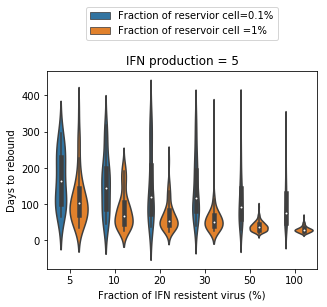

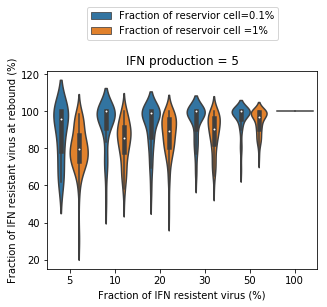

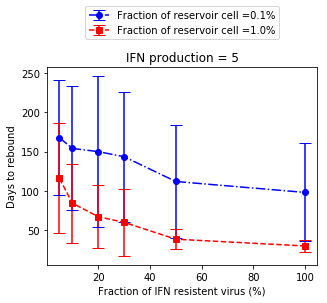

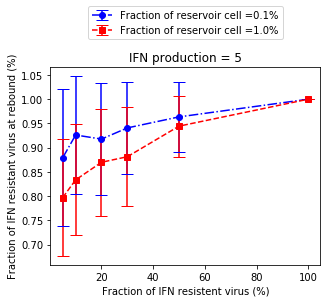

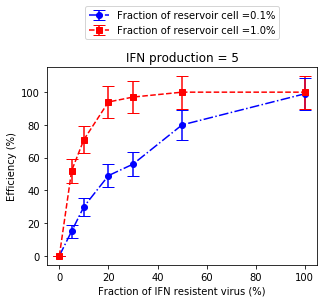

0

In [180]:
PlotVirusTypeRatioATThreshold_virustyperatio_violin(df22)
PlotVirusTypeRatioATThreshold_virustyperatio(df32)
PlotVirusTypeRatioATThreshold_virustyperatio_efficiency(df32)

In [177]:
def PlotVirusTypeRatioATThreshold_resratio(df):
    colors=['blue', 'red']
    linestyles = ['-.','--']
    markers = ['o','s']

    for iifn_prod in df["ifn_prod"].unique():
        df1=df[(df['ifn_prod']==iifn_prod)]
        count1=0
        count2=0
        plt.figure(figsize=(5, 5))
        for ivirus_type_ratio in df["virus_type_ratio"].unique():  
            df2=df1[(df1["virus_type_ratio"]==ivirus_type_ratio)]
            plt.errorbar(df2['res_ratio'],df2["step_threshold_mean"]/step, yerr=df2["step_threshold_std"]/step, color=colors[count1],marker = markers[count1],capsize=6,linestyle=linestyles[count1],label="Fraction of IFN resistent cell ={}%".format(ivirus_type_ratio))
            count1=count1+1
        plt.title("IFN production = {}".format(iifn_prod))
        plt.ylabel("Days to rebound")
        plt.xlabel("Fraction of reservoir cell (%)")
        plt.subplots_adjust(left=0.15, right=0.9, top=0.7, bottom=0.15)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.33),ncol=1)
        plt.savefig("./figure/daystorebound_resratio_ifnprod{}.pdf".format(iifn_prod))
        plt.show()   
        
        plt.figure(figsize=(5, 5))
        for ivirus_type_ratio in df["virus_type_ratio"].unique():  
            df2=df1[(df1["virus_type_ratio"]==ivirus_type_ratio)]
            plt.errorbar(df2['res_ratio'],df2["virustyperatio_threshold_mean"], yerr=df2["virustyperatio_threshold_std"], color=colors[count2],marker = markers[count2],capsize=6,linestyle=linestyles[count2],label="Fraction of IFN resistent cell ={}%".format(ivirus_type_ratio))
            count2=count2+1
        plt.title("IFN production = {}".format(iifn_prod))
        plt.ylabel("Fraction of IFN resistant virus at rebound (%)")
        plt.xlabel("Fraction of reservoir cell (%)")
        plt.subplots_adjust(left=0.15, right=0.9, top=0.7, bottom=0.15)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.33),ncol=1)
        plt.savefig("./figure/virustyperatio_resratio_ifnprod{}.pdf".format(iifn_prod))
        plt.show()         
    return 0

def PlotVirusTypeRatioATThreshold_resratio_violin(df):
    colors=['blue', 'red']
    linestyles = ['-.','--']
    markers = ['o','s']


    for iifn_prod in df["ifn_prod"].unique():
        df1=df[(df['ifn_prod']==iifn_prod)]
        plt.figure(figsize=(5, 5))
        ax=sns.violinplot(x="res_ratio",y=df1["step_threshold"].astype(float)/step,hue="virus_type_ratio",data=df1)
        plt.title("IFN production = {}".format(iifn_prod))
        plt.ylabel("Days to rebound")
        plt.xlabel("Fraction of reservoir cell (%)")
        plt.subplots_adjust(left=0.15, right=0.9, top=0.7, bottom=0.15)
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),ncol=1,handles=ax.legend_.legendHandles,labels=['Fraction of IFN resistent virus=10%', 'Fraction of IFN resistent virus=50%'])
        plt.savefig("./figure/daystorebound_restratio_ifnprod{}_violin.pdf".format(iifn_prod))
        plt.show()   
        
        plt.figure(figsize=(5, 5))
        ax=sns.violinplot(x="res_ratio",y=100*df1["virustyperatio_threshold"],hue="virus_type_ratio",data=df1)
        plt.title("IFN production = {}".format(iifn_prod))
        plt.ylabel("Fraction of IFN resistant virus at rebound (%)")
        plt.xlabel("Fraction of reservoir cell (%)")
        plt.subplots_adjust(left=0.15, right=0.9, top=0.7, bottom=0.15)
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),ncol=1,handles=ax.legend_.legendHandles,labels=['Fraction of IFN resistent virus=10%', 'Fraction of IFN resistent virus=50%'])
        plt.savefig("./figure/virustyperatio_restratio_ifnprod{}_violin.pdf".format(iifn_prod))
        plt.show()         

    return 0

def PlotVirusTypeRatioATThreshold_resratio_efficiency(df):
    colors=['blue', 'red']
    linestyles = ['-.','--']
    markers = ['o','s']
    count2=0
    for iifn_prod in df["ifn_prod"].unique():
        df1=df[(df['ifn_prod']==iifn_prod)]
        plt.figure(figsize=(5, 5))
        for ivirus_type_ratio in df["virus_type_ratio"].unique():  
            df2=df1[(df1["virus_type_ratio"]==ivirus_type_ratio)]
            plt.errorbar(df2['res_ratio'],df2["efficiency"]*100, yerr=df2["eff_unc"]*100, color=colors[count2],marker = markers[count2],capsize=6,linestyle=linestyles[count2],label="Fraction of IFN resistent cell ={}%".format(ivirus_type_ratio))
            count2=count2+1
        plt.title("IFN production = {}".format(iifn_prod))
        plt.ylabel("Efficiency (%)")
        plt.xlabel("Fraction of reservoir cell (%)")
        plt.subplots_adjust(left=0.15, right=0.9, top=0.7, bottom=0.15)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.33),ncol=1)
        plt.savefig("./figure/daystorebound_restratio_ifnprod{}_eff.pdf".format(iifn_prod))
        plt.show()   
    return 0

/Users/pchu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


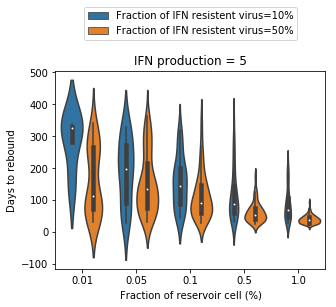

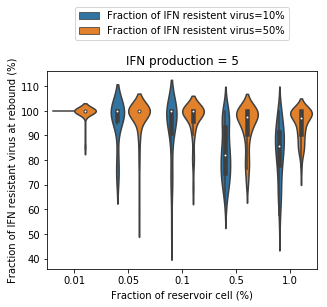

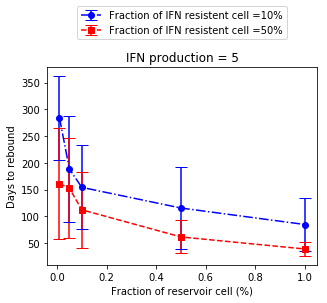

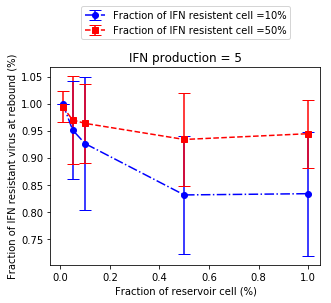

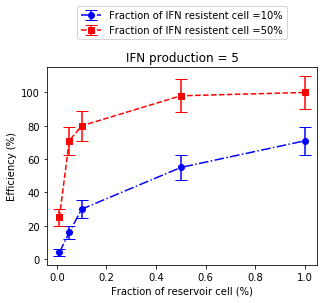

0

In [178]:
PlotVirusTypeRatioATThreshold_resratio_violin(df23)
PlotVirusTypeRatioATThreshold_resratio(df33)
PlotVirusTypeRatioATThreshold_resratio_efficiency(df33)